### Modeling
- modeling off of multiple prior years for shorter timeframe
- includes nighttime hours

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
%matplotlib inline

import pickle

In [108]:
def mape(observations, estimates):
    '''
    INPUT:
        observations - numpy array of values indicating observed values
        estimates - numpy array of values indicating an estimate of values
    OUTPUT:
        Mean Absolute Percentage Error value
    '''
    # check arg types
    assert type(observations) == type(np.array([])), "'observations' must be a numpy array"
    assert type(estimates) == type(np.array([])), "'estimates' must be a numpy array"
    # check length of arrays equal
    assert len(observations) == len(estimates), "Arrays must be of equal length"
    
    # calculations
    difference = abs((observations - estimates)/observations)
    mape = sum(difference)/len(observations)*100
    
    return mape

In [109]:
def mse(observations, estimates):
    '''
    INPUT:
        observations - numpy array of values indicating observed values
        estimates - numpy array of values indicating an estimate of values
    OUTPUT:
        Mean Square Error value
    '''
    # check arg types
    assert type(observations) == type(np.array([])), "'observations' must be a numpy array"
    assert type(estimates) == type(np.array([])), "'estimates' must be a numpy array"
    # check length of arrays equal
    assert len(observations) == len(estimates), "Arrays must be of equal length"
    
    # calculations
    difference = observations - estimates
    sq_diff = difference ** 2
    mse = sum(sq_diff)
    
    return mse

In [110]:
dataset = 'PGE-CSI-00114'

with open('pickles/data_'+dataset+'_train0.pickle', 'rb') as to_read:
    data_train = pickle.load(to_read)
with open('pickles/data_'+dataset+'_test0.pickle', 'rb') as to_read:
    data_test = pickle.load(to_read)

In [193]:
with open('pickles/weather_fresno.pickle', 'rb') as to_read:
    weather = pickle.load(to_read)
    
with open('pickles/solar_fresno.pickle', 'rb') as to_read:
    solar = pickle.load(to_read)

In [112]:
print(data_train.shape)
print(data_test.shape)
print(weather.shape)

(43824,)
(8784,)
(77917, 13)


In [113]:
#let's start with july 2015
# train:test 3:1
# data_train1 = data_train[dt.datetime(2015,7,1,0,0):dt.datetime(2015,7,21,23,0)]
# data_test1 = data_train[dt.datetime(2015,7,22,0,0):dt.datetime(2015,7,28,23,0)]

#nov 2015
# train:test 7:1
# data_train1 = data_train[dt.datetime(2015,11,1,0,0):dt.datetime(2015,12,21,23,0)]
# data_test1 = data_train[dt.datetime(2015,12,22,0,0):dt.datetime(2015,12,28,23,0)]
data_train1 = data_train[dt.datetime(2014,12,1,0,0):dt.datetime(2015,1,21,23,0)]
data_test1 = data_train[dt.datetime(2015,1,22,0,0):dt.datetime(2015,1,28,23,0)]

print(data_train1.shape)
print(data_test1.shape)

(1248,)
(168,)


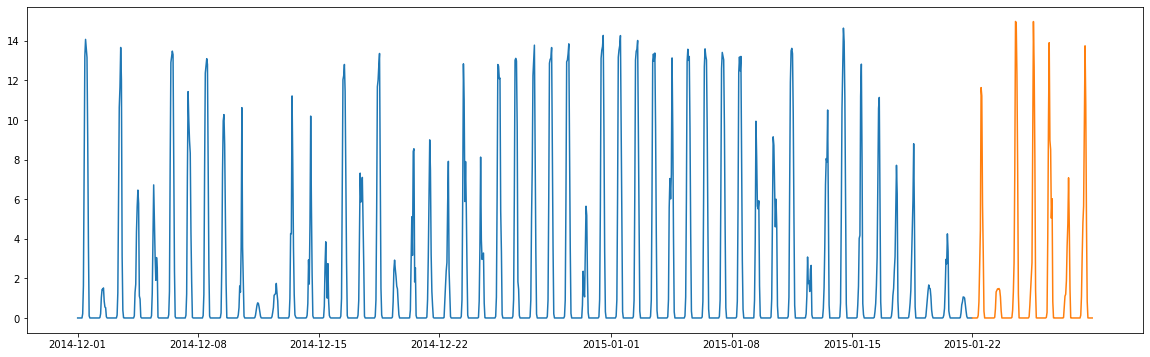

In [114]:
plt.figure(figsize=(20,6))
# plt.plot(data_train1[data_train1.index.year==2015]);
plt.plot(data_train1)
plt.plot(data_test1);

### Decomposition

In [115]:
from statsmodels.tsa.seasonal import seasonal_decompose

ss_decomposition = seasonal_decompose(x=data_train1, model='additive', freq=24) # what is freq supposed to be?
estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual = ss_decomposition.resid

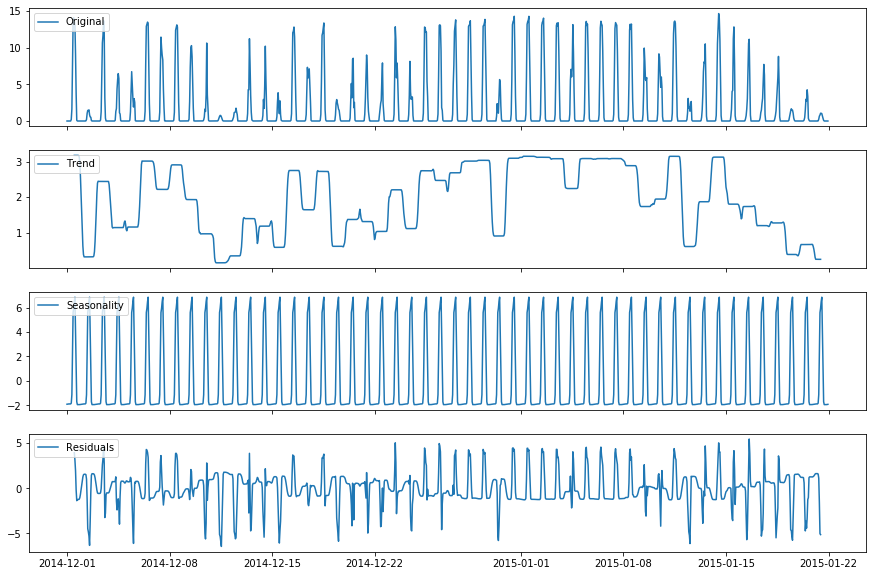

In [116]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(data_train1, label='Original')
axes[0].legend(loc='upper left');

axes[1].plot(estimated_trend, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(estimated_seasonal, label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(estimated_residual, label='Residuals')
axes[3].legend(loc='upper left');

### Stationarity testing

In [117]:
from statsmodels.tsa.stattools import adfuller

adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(data_train1)
print(pvalue)

0.008551589195591408


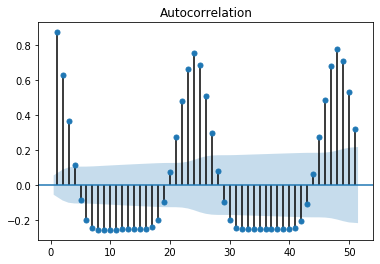

In [118]:
from statsmodels.graphics.tsaplots import plot_acf

fig = plot_acf(data_train1, lags=range(1,52), alpha=0.05)

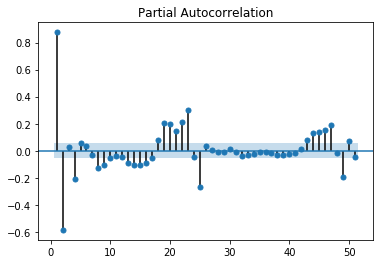

In [119]:
### Choosing p
from statsmodels.graphics.tsaplots import plot_pacf

fig = plot_pacf(data_train1, lags=range(1,52), alpha=0.05)

In [120]:
# define helper plot function for visualization
import statsmodels.tsa.api as smt

def plots(data, lags=None):
    layout = (1, 3)
    plt.figure(figsize=(20,6))
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    data.plot(ax=raw)
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
#     plt.tight_layout()

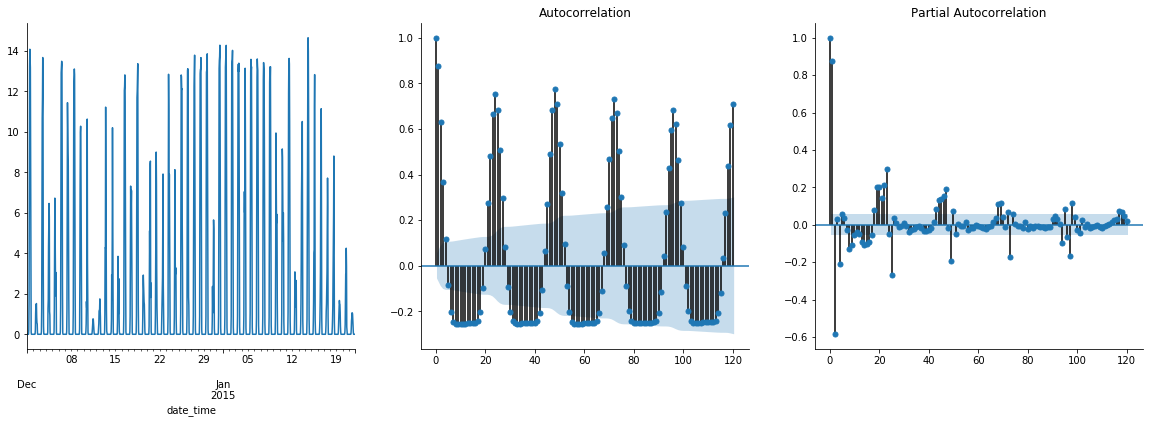

In [121]:
# helper plot for temps
plots(data_train1, lags=120);

### Differencing

In [122]:
# check daily deviations for various diffs
print(data_train1.std())
print(data_train1.diff().std()) 
print(data_train1.diff().diff().std()) # second order differencing is lowest STD but that might be overdoing it
print(data_train1.diff().diff().diff().std())

3.777390900455438
1.8824219036065026
1.9126748027264275
2.8383408632895826


differencing reduces STD but data is already stationary

### Modeling

In [123]:
# we might need to install dev version for statespace functionality
#!pip install git+https://github.com/statsmodels/statsmodels.git
import statsmodels.api as sm

# fit SARIMA monthly based on helper plots
sar = sm.tsa.statespace.SARIMAX(data_train1, 
                                order=(1,1,1), 
                                seasonal_order=(0,1,1,24), 
                                trend='c').fit()
sar.summary()

# increasing non-seasonal AR adds overall increasing trend over time

# best for two week train 1 week test:
# order=(1,1,1), 
# seasonal_order=(0,1,0,24), 

# best for 7 week train 1 week test:
# order=(1,1,1), 
# seasonal_order=(0,1,1,24), 
# moving average seems to be better - day to day weather is variable but on average the past few weeks are 
# probably more informative

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                kWh   No. Observations:                 1248
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 24)   Log Likelihood               -1941.386
Date:                            Thu, 05 Dec 2019   AIC                           3892.772
Time:                                    12:55:38   BIC                           3918.318
Sample:                                12-01-2014   HQIC                          3902.386
                                     - 01-21-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -5.45e-06      0.011     -0.001      1.000      -0.021       0.021
ar.L1         -0.2235      0.054     -4.137      0.000      -0.329      -0.118
ma.L1          0.5310      0.049     10.827      0.000       0.435       0.627
ma.S.L24      -0.8212      0.010    -78.668      0.000      -0.842      -0.801
sigma2         1.3700      0.025     54.753      0.000       1.321       1.419
===================================================================================
Ljung-Box (Q):                       85.56   Jarque-Bera (JB):              4350.40
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.75   Skew:                             0.74
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

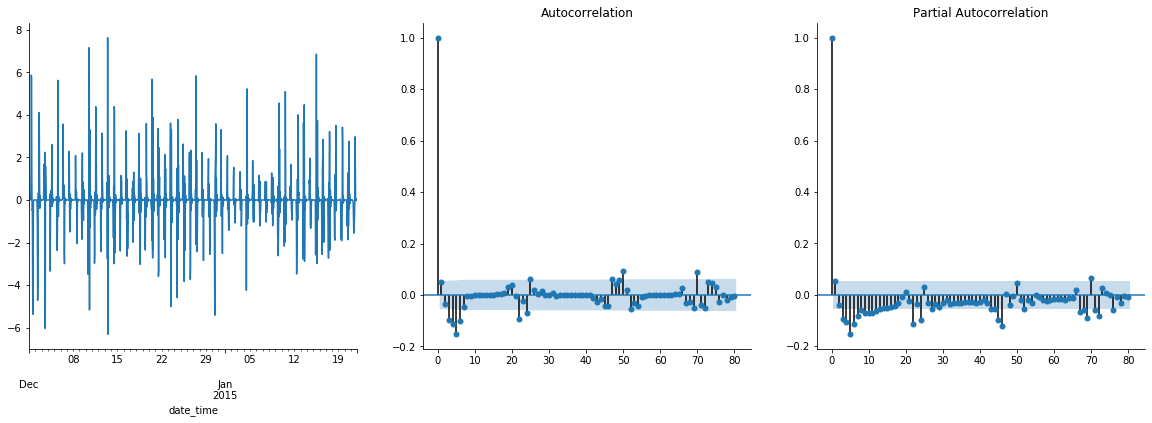

In [124]:
# plot resids
plots(sar.resid, lags=80);

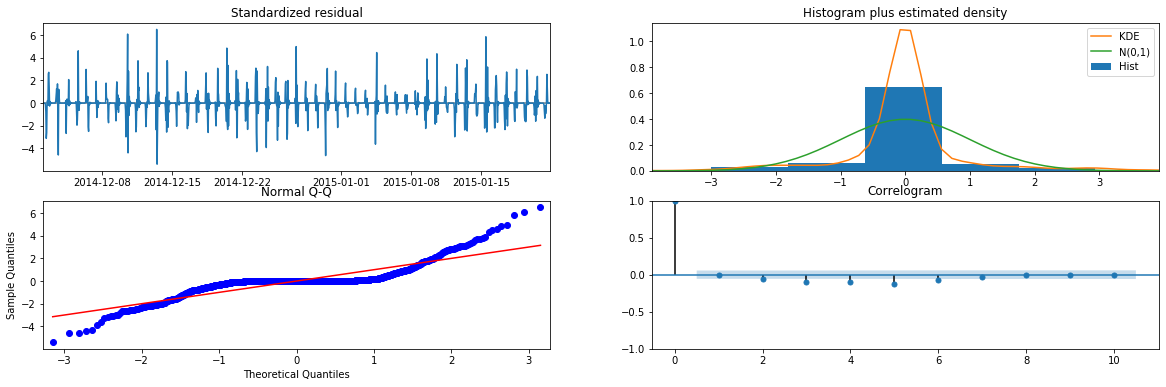

In [125]:
# plot residual diagnostics
sar.plot_diagnostics(figsize=(20,6));

In [126]:
y_pred = sar.predict(start=0,end=len(data_train1)-1,dynamic=False)
print(type(y_pred))

#floor data at 0 (can't have negative values, which appear to be momentum)
for i,val in y_pred.iteritems():
    if val < 0 :
        y_pred[i]=0
print(type(y_pred))
# y_pred2 = sar.predict(start=len(data_train)+1,end=(len(data_train)+len(data_test)),dynamic=False)

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


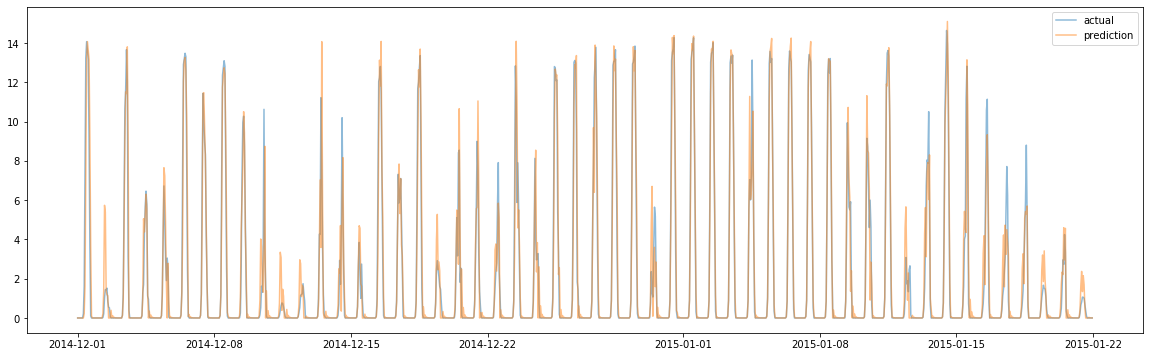

In [127]:
plt.figure(figsize=(20,6))
plt.plot(data_train1.index, data_train1.values,alpha=0.5,label='actual')
plt.plot(data_train1.index, y_pred.values,alpha=0.5,label='prediction')
plt.legend();

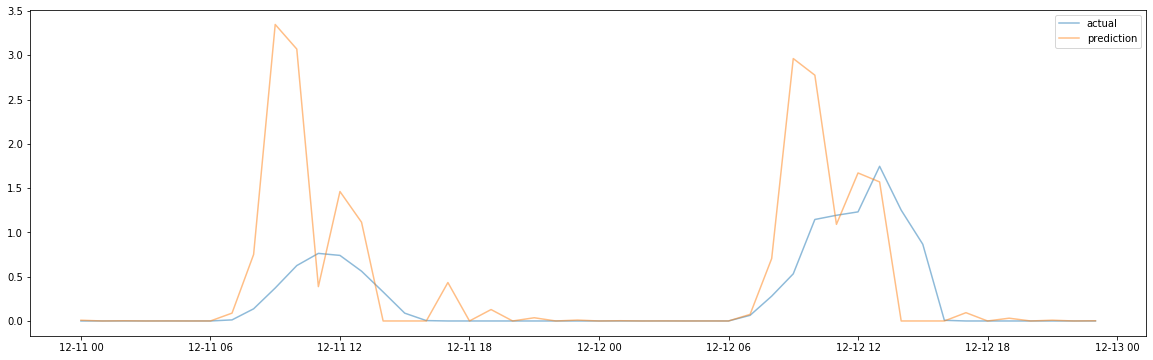

In [128]:
start = 240
end = start+48
plt.figure(figsize=(20,6))
plt.plot(data_train1.index[start:end], data_train1.values[start:end],alpha=0.5,label='actual')
plt.plot(data_train1.index[start:end], y_pred.values[start:end],alpha=0.5,label='prediction')
plt.legend();

### forecast future

In [129]:
a = data_test1.shape[0]
data_for = sar.forecast(steps=a)
print(data_for.shape)
print(data_train1.shape)

(168,)
(1248,)


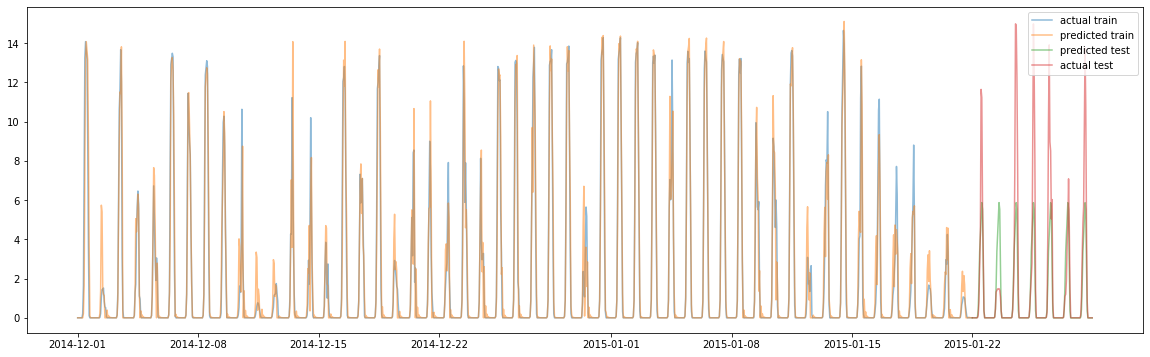

In [130]:
plt.figure(figsize=(20,6))
plt.plot(data_train1.index, data_train1.values,alpha=0.5,label='actual train')
plt.plot(data_train1.index, y_pred.values,alpha=0.5,label='predicted train')
plt.plot(data_for.index,data_for,alpha=0.5,label='predicted test')
plt.plot(data_test1.index,data_test1.values,alpha=0.5,label='actual test')
plt.legend();

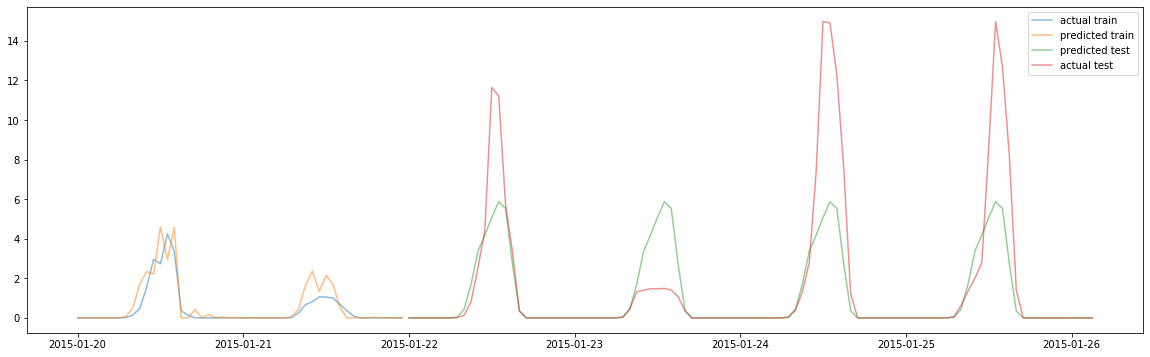

In [131]:
# start = 1040
# end = 1095
start = 1200
end = 1248
# end = len(data_train1)+len(data_test1)+1
plt.figure(figsize=(20,6))
plt.plot(data_train1.index[start:end], data_train1.values[start:end],alpha=0.5,label='actual train')
plt.plot(data_train1.index[start:end], y_pred.values[start:end],alpha=0.5,label='predicted train')
plt.plot(data_for.index[0:100],data_for[0:100],alpha=0.5,label='predicted test')
plt.plot(data_test1.index[0:100],data_test1.values[0:100],alpha=0.5,label='actual test')
plt.legend();

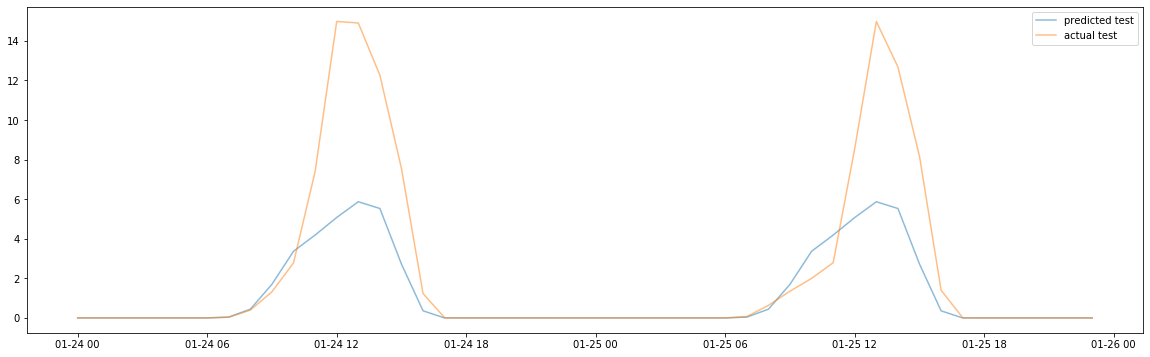

In [132]:
start = 48
end = start+48
plt.figure(figsize=(20,6))
plt.plot(data_for.index[start:end],data_for[start:end],alpha=0.5,label='predicted test')
plt.plot(data_test1.index[start:end],data_test1.values[start:end],alpha=0.5,label='actual test')
plt.legend();

In [133]:
print('MSE Train:',mse(data_train1.values,y_pred.values))
print('MSE Test:',mse(data_test1.values,data_for.values))
print('RMSE Train:',np.sqrt(mse(data_train1.values,y_pred.values)))
print('RMSE Test:',np.sqrt(mse(data_test1.values,data_for.values)))

MSE Train: 1627.9722343961878
MSE Test: 900.3288773510972
RMSE Train: 40.34813792972592
RMSE Test: 30.005480788534236


### evaluate - see if model improves with adding more historical data
it should improve - more data should better inform the future

In [170]:
def loop_model(train_start,train_end,test_start,test_end):
    '''
    1. subset the train data according to specified lengths
    2. fit model on train data
    3. plot results
    4. evaluate performance
    '''
    data_train1 = data_train[train_start:train_end]
    data_test1 = data_train[test_start:test_end]
    
    sar = sm.tsa.statespace.SARIMAX(data_train1, 
                                order=(1,1,1), 
                                seasonal_order=(0,1,1,24), 
                                trend='c').fit()
    
    y_pred = sar.predict(start=0,end=len(data_train1)-1,dynamic=False)
    print(type(y_pred))

    #floor data at 0 (can't have negative values, which appear to be momentum)
    for i,val in y_pred.iteritems():
        if val < 0 :
            y_pred[i]=0
#     print(type(y_pred))

    a = data_test1.shape[0]
    data_for = sar.forecast(steps=a)
    
    plt.figure(figsize=(20,6))
    plt.plot(data_train1.index, data_train1.values,alpha=0.5,label='actual train')
    plt.plot(data_train1.index, y_pred.values,alpha=0.5,label='predicted train')
    plt.plot(data_for.index,data_for,alpha=0.5,label='predicted test')
    plt.plot(data_test1.index,data_test1.values,alpha=0.5,label='actual test')
    plt.legend();
    
    #subset train
    plt.figure(figsize=(20,6))
    plt.plot(data_train1.index[0:72], data_train1.values[0:72],alpha=0.5,label='actual train')
    plt.plot(data_train1.index[0:72], y_pred.values[0:72],alpha=0.5,label='predicted train')
    plt.legend()
    plt.show();
    
    #subset test
    plt.figure(figsize=(20,6))
    plt.plot(data_for.index,data_for,alpha=0.5,label='predicted test')
    plt.plot(data_test1.index,data_test1.values,alpha=0.5,label='actual test')
    plt.legend()
    plt.show();

    print('MSE Train:',mse(data_train1.values,y_pred.values))
    print('MSE Test:',mse(data_test1.values,data_for.values))
    print('RMSE Train:',np.sqrt(mse(data_train1.values,y_pred.values)))
    print('RMSE Test:',np.sqrt(mse(data_test1.values,data_for.values)))
    return

<class 'pandas.core.series.Series'>


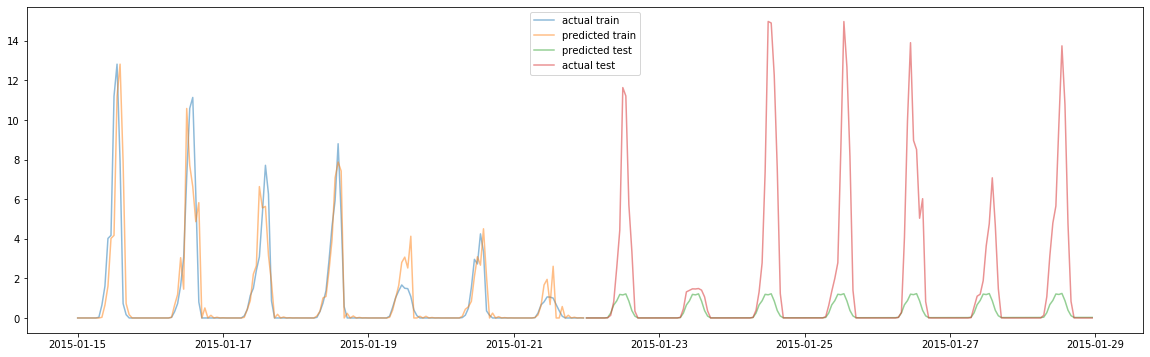

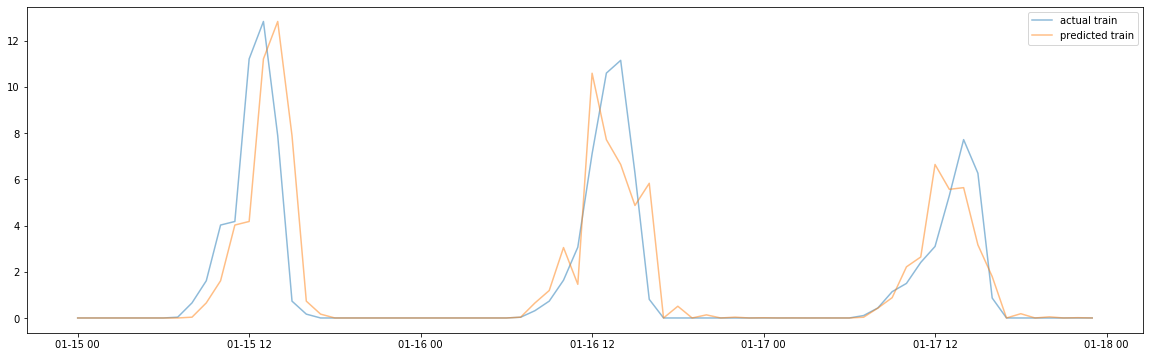

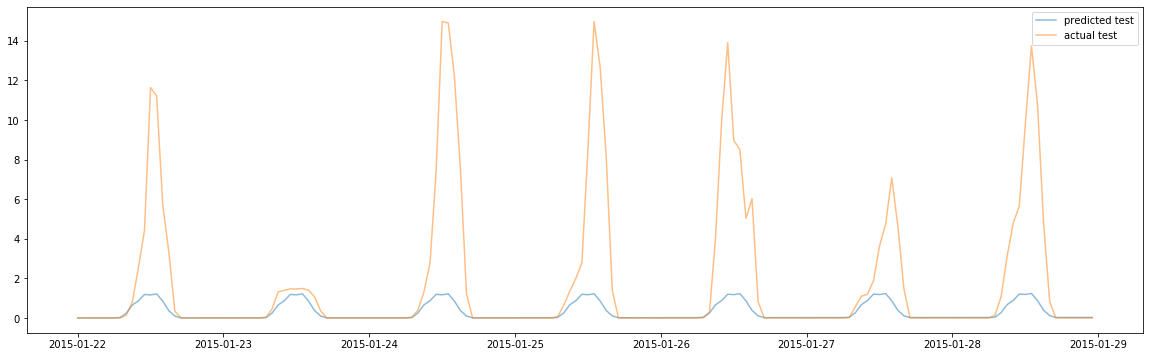

MSE Train: 272.62909406767596
MSE Test: 2199.1588860903485
RMSE Train: 16.511483702795335
RMSE Test: 46.89519043665724


In [171]:
#1 week prior
loop_model(dt.datetime(2015,1,15,0,0),
           dt.datetime(2015,1,21,23,0),
           dt.datetime(2015,1,22,0,0),
           dt.datetime(2015,1,28,23,0))       

<class 'pandas.core.series.Series'>


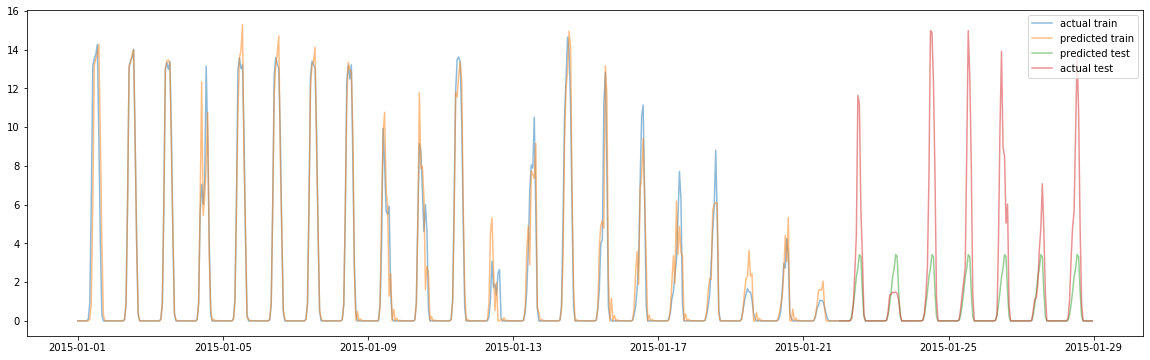

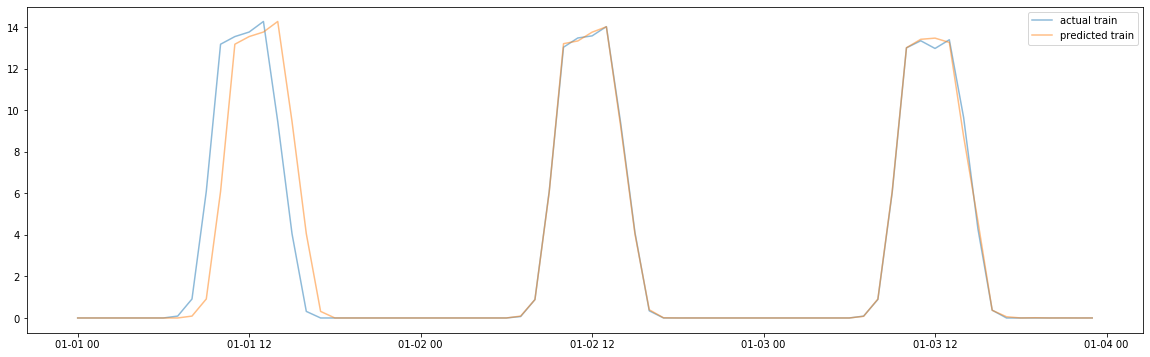

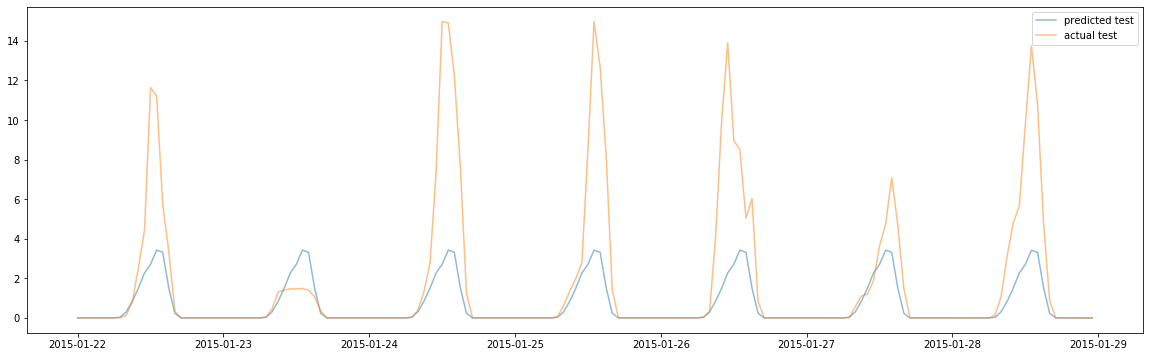

MSE Train: 576.8956831484795
MSE Test: 1483.1496423045128
RMSE Train: 24.01865281710195
RMSE Test: 38.51168189399825


In [136]:
#1 month prior
loop_model(dt.datetime(2015,1,1,0,0),
           dt.datetime(2015,1,21,23,0),
           dt.datetime(2015,1,22,0,0),
           dt.datetime(2015,1,28,23,0))

<class 'pandas.core.series.Series'>


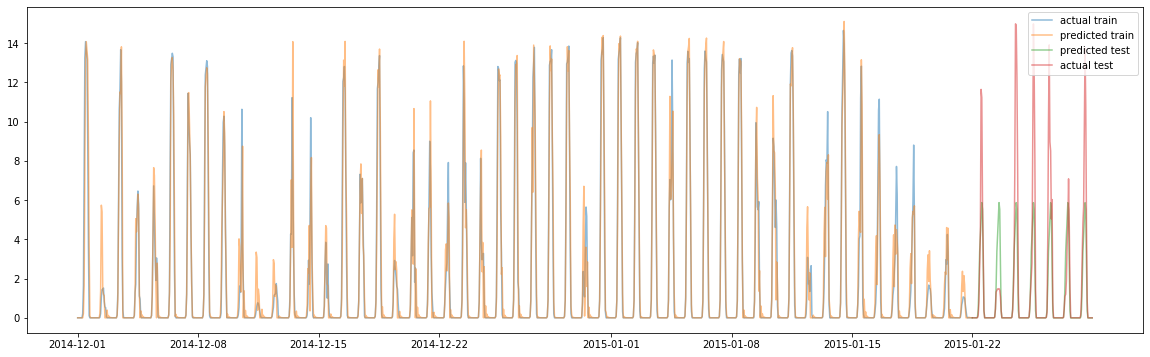

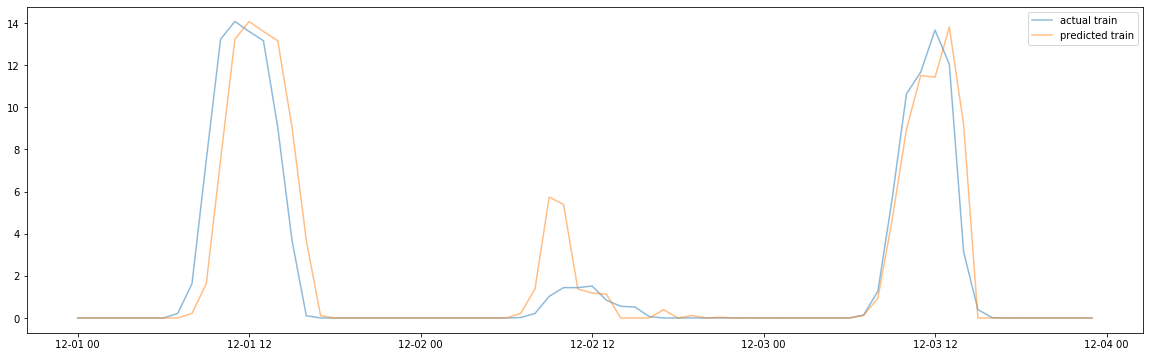

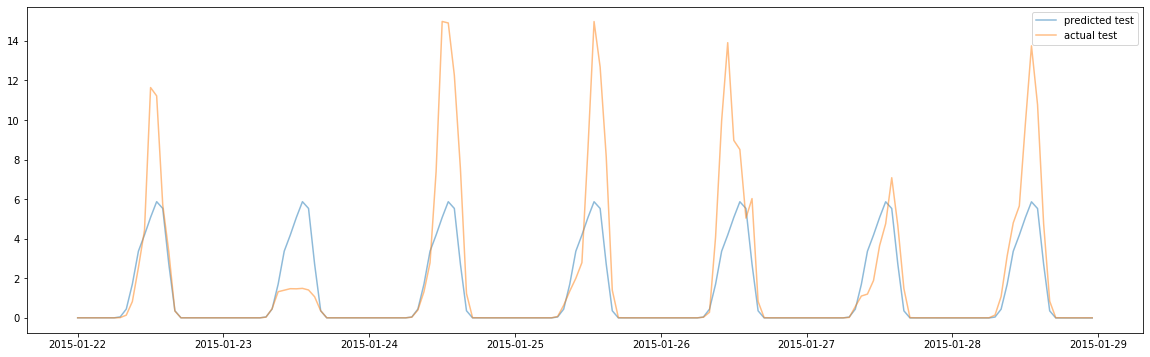

MSE Train: 1627.9722343961878
MSE Test: 900.3288773510972
RMSE Train: 40.34813792972592
RMSE Test: 30.005480788534236


In [172]:
#2 months prior
loop_model(dt.datetime(2014,12,1,0,0),
           dt.datetime(2015,1,21,23,0),
           dt.datetime(2015,1,22,0,0),
           dt.datetime(2015,1,28,23,0))

In [138]:
#3 months prior
# loop_model(dt.datetime(2014,11,1,0,0),
#            dt.datetime(2015,1,21,23,0),
#            dt.datetime(2015,1,22,0,0),
#            dt.datetime(2015,1,28,23,0))

In [139]:
#4 months prior
# loop_model(dt.datetime(2014,10,1,0,0),
#            dt.datetime(2015,1,21,23,0),
#            dt.datetime(2015,1,22,0,0),
#            dt.datetime(2015,1,28,23,0))

In [140]:
#6 months prior
# loop_model(dt.datetime(2014,8,1,0,0),
#            dt.datetime(2015,1,21,23,0),
#            dt.datetime(2015,1,22,0,0),
#            dt.datetime(2015,1,28,23,0))

### Add weather as exogenous variables

In [207]:
def loop_model2(train_start,train_end,test_start,test_end):
    '''
    1. subset the train data according to specified lengths
    2. fit model on train data
    3. plot results
    4. evaluate performance
    '''
    data_train1 = data_train[train_start:train_end]
    data_test1 = data_train[test_start:test_end]
    
    weather_train1 = weather[['HourlyPrecipitation','cloud_layer','cloud_base_height','sunlight']][train_start:train_end]
    weather_test1 = weather[['HourlyPrecipitation','cloud_layer','cloud_base_height','sunlight']][test_start:test_end]

    solar_train1 = solar[train_start:train_end]
    solar_test1 = solar[test_start:test_end]
    
    print(data_train1.shape)
    print(data_test1.shape)
    print(weather_train1.values.shape)
    print(weather_test1.values.shape)
    print(solar_train1.values.shape)
    print(solar_test1.values.shape)
    
    sar = sm.tsa.statespace.SARIMAX(data_train1,
#                                 exog=weather_train1.values,
                                exog=solar_train1.values,
                                order=(1,1,1), 
                                seasonal_order=(0,1,1,24), 
                                trend='c').fit(maxiter=00)
    
    y_pred = sar.predict(start=0,end=len(data_train1)-1,dynamic=False)
    print(type(y_pred))

    a = data_test1.shape[0]
    data_for = sar.forecast(steps=a,exog=solar_test1.values)
#     data_for = sar.forecast(steps=a,exog=weather_test1.values)
#     data_for = sar.forecast(steps=a)
    
    #remove non-0 data during night hours (can't have negative values, which appear to be momentum)
    for i,val in y_pred.iteritems():
        if weather_train1['sunlight'][i] == 0 :
            y_pred[i]=0
        if val < 0 :
            y_pred[i]=0
    for i,val in data_for.iteritems():
        if weather_test1['sunlight'][i] == 0 :
            data_for[i]=0
        if val < 0 :
            data_for[i]=0
        

    #full data
    plt.figure(figsize=(20,6))
    plt.plot(data_train1.index, data_train1.values,alpha=0.5,label='actual train')
    plt.plot(data_train1.index, y_pred.values,alpha=0.5,label='predicted train')
    plt.plot(data_test1.index,data_test1.values,alpha=0.5,label='actual test')
    plt.plot(data_for.index,data_for,alpha=0.5,label='predicted test')
    plt.title('full data')
    plt.legend()
    plt.show();

    #subset train
    plt.figure(figsize=(20,6))
    plt.plot(data_train1.index[0:72], data_train1.values[0:72],alpha=0.5,label='actual train')
    plt.plot(data_train1.index[0:72], y_pred.values[0:72],alpha=0.5,label='predicted train')
    plt.title('subset of train data')
    plt.legend()
    plt.show();
    
    #test only
    plt.figure(figsize=(20,6))
    plt.plot(data_test1.index,data_test1.values,alpha=0.5,label='actual test')
    plt.plot(data_for.index,data_for,alpha=0.5,label='predicted test')
    plt.title('test data')
    plt.legend()
    plt.show();
    
    #weather test
    plt.figure(figsize=(20,6))
    
    plt.plot(solar_test1.index,solar_test1['DHI'],alpha=0.5,label='DHI')
    plt.plot(solar_test1.index,solar_test1['DNI'],alpha=0.5,label='DNI')
    plt.plot(solar_test1.index,solar_test1['GHI'],alpha=0.5,label='GHI')
#     plt.plot(weather_test1.index,weather_test1['HourlyPrecipitation'],alpha=0.5,label='precipitation')
#     plt.plot(weather_test1.index,weather_test1['HourlyDryBulbTemperature'],alpha=0.5,label='temp')
#     plt.plot(weather_test1.index,weather_test1['HourlyRelativeHumidity'],alpha=0.5,label='humidity')
#     plt.plot(weather_test1.index,weather_test1['cloud_layer'],alpha=0.5,label='cloud layer')    
#     plt.plot(weather_test1.index,weather_test1['cloud_base_height'],alpha=0.5,label='cloud base hieght')
    plt.title('test weather')
    plt.legend()
    plt.show();
    
    print('MSE Train:',mse(data_train1.values,y_pred.values))
    print('MSE Test:',mse(data_test1.values,data_for.values))
    print('RMSE Train:',np.sqrt(mse(data_train1.values,y_pred.values)))
    print('RMSE Test:',np.sqrt(mse(data_test1.values,data_for.values)))
    
    #calculate MAPE for non-zero values
#     for dataset in [data_train1,y_pred,data_test1,data_for]:
    for j,v in data_train1.iteritems():
        if data_train1[j]==0:
            data_train1.pop(j)
            y_pred.pop(j)
    for k,a in data_test1.iteritems():
        if data_test1[k]==0:
            data_test1.pop(k)
            data_for.pop(k)
    
                
    print('MAPE Train:',mape(data_train1.values,y_pred.values))
    print('MAPE Test:',mape(data_test1.values,data_for.values))
    
    print(sar.mle_retvals)
    return

(1248,)
(168,)
(1248, 4)
(168, 4)
(1248, 3)
(168, 3)
<class 'pandas.core.series.Series'>


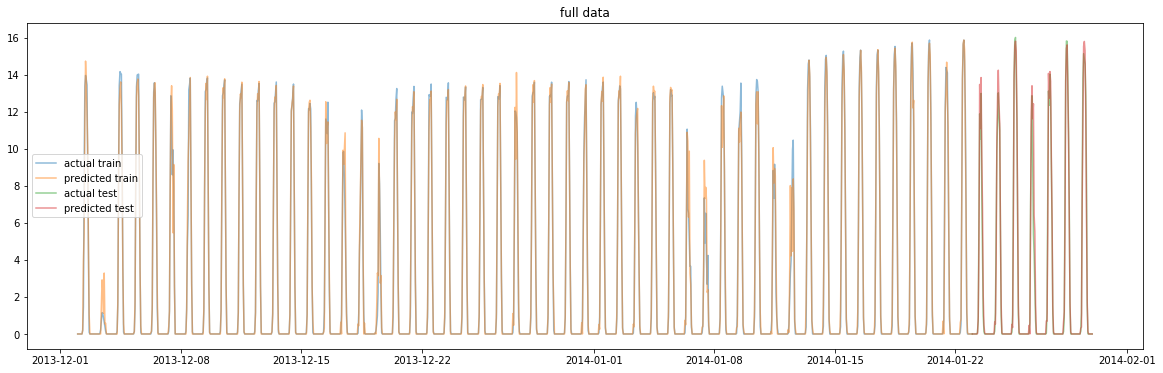

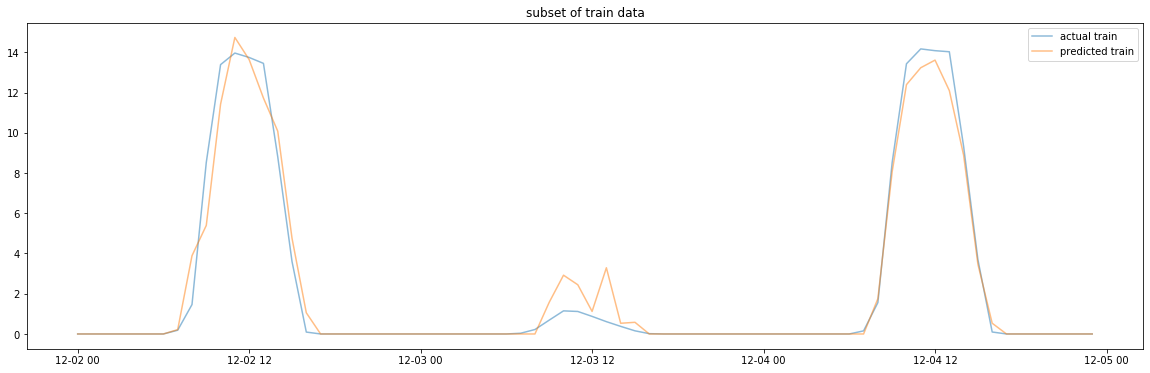

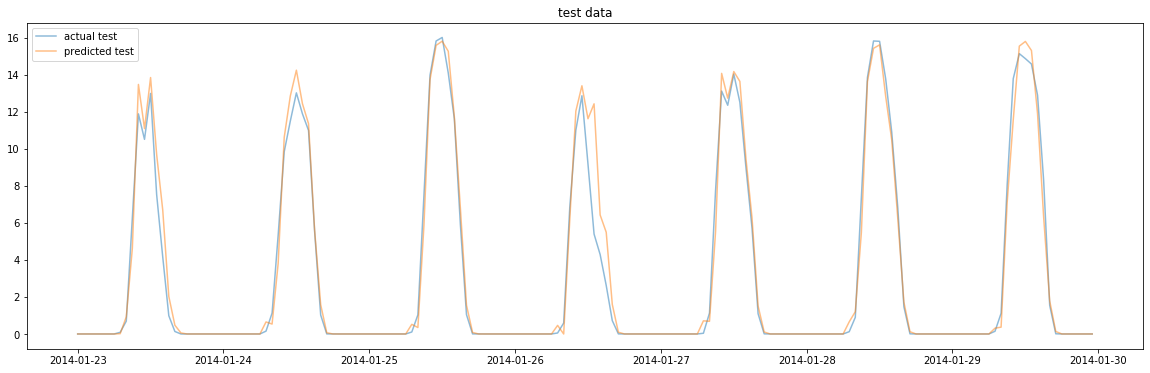

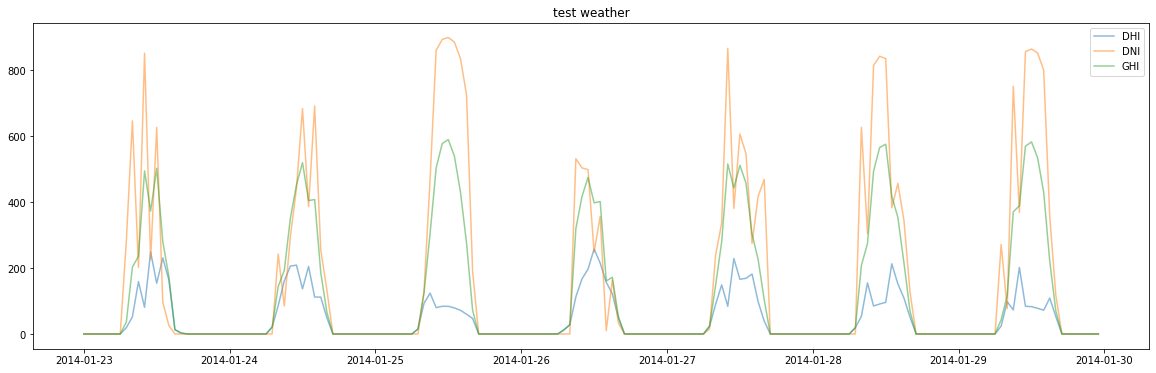

MSE Train: 421.0644515285429
MSE Test: 130.90284364037757
RMSE Train: 20.51985505622647
RMSE Test: 11.441278059743919
MAPE Train: 1013.46775459716
MAPE Test: 1980.0985510127114
{'fopt': 0.8510154139233682, 'gopt': array([ 2.47554002e+00,  7.53296088e-02, -6.20092950e-01, -8.80216934e-02,
        4.06309724e-03,  4.51950699e-05,  1.08191508e-02, -1.08942118e-01]), 'fcalls': 1710, 'warnflag': 0, 'converged': True, 'iterations': 145}


In [208]:
#1
loop_model2(dt.datetime(2013,12,2,0,0),
           dt.datetime(2014,1,22,23,0),
           dt.datetime(2014,1,23,0,0),
           dt.datetime(2014,1,29,23,0))  

(1248,)
(168,)
(1248, 4)
(168, 4)
(1248, 3)
(168, 3)
<class 'pandas.core.series.Series'>


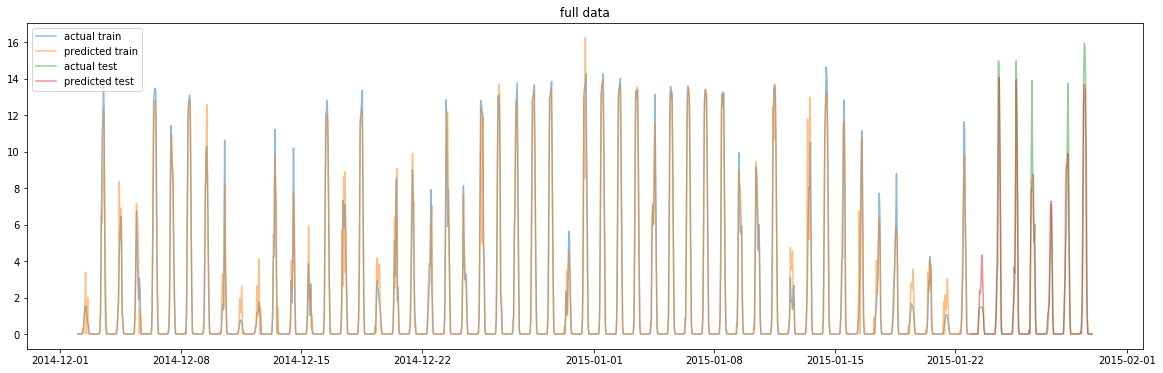

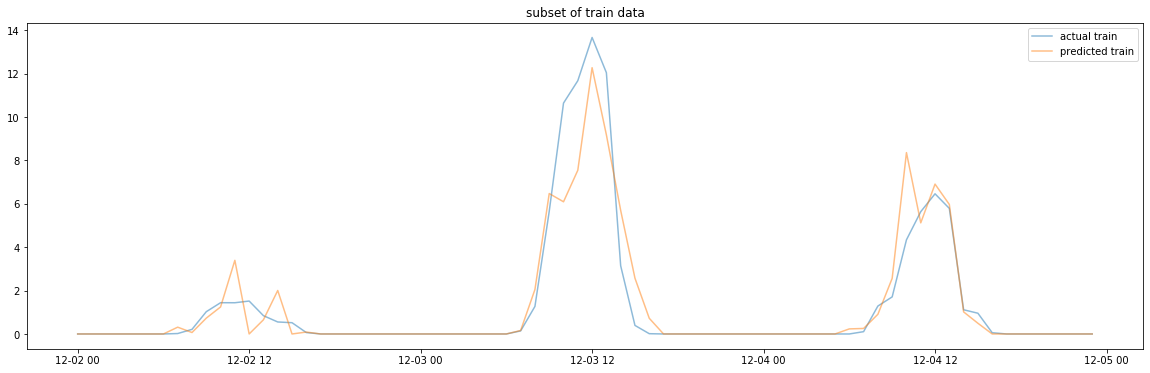

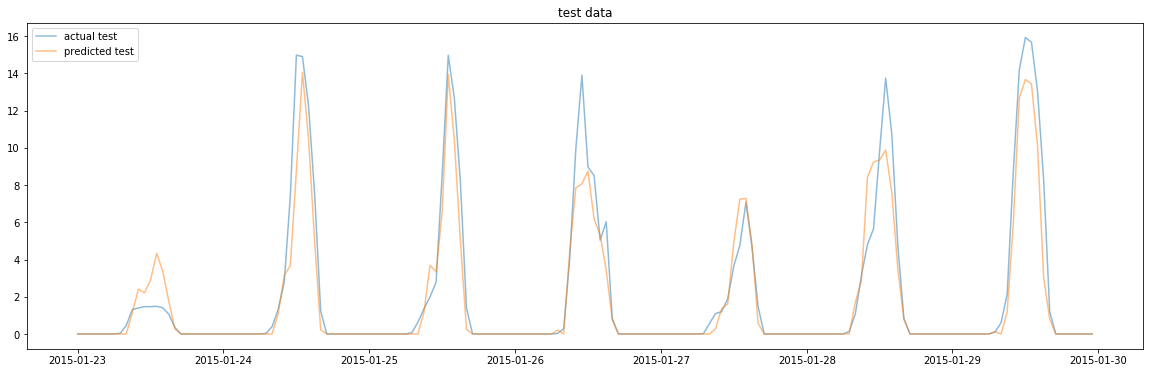

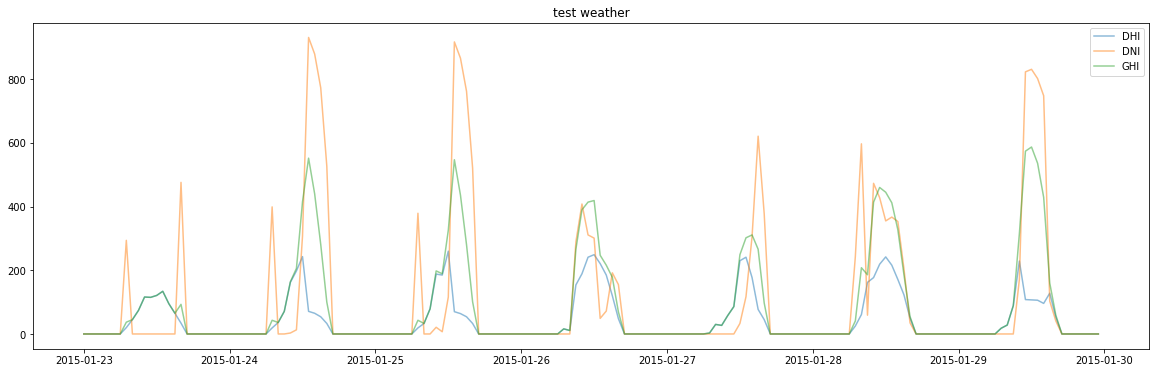

MSE Train: 984.0056102820643
MSE Test: 277.7552057412177
RMSE Train: 31.36886370721873
RMSE Test: 16.66598949181289
MAPE Train: 545.0285198259071
MAPE Test: 59.82110123424197
{'fopt': 1.3047112953174387, 'gopt': array([ 0.01786759,  0.00224194, -0.00025357,  0.00153697,  0.00182869,
        0.00982895, -0.00933109, -0.00044564]), 'fcalls': 675, 'warnflag': 0, 'converged': True, 'iterations': 60}


In [209]:
#2
loop_model2(dt.datetime(2014,12,2,0,0),
           dt.datetime(2015,1,22,23,0),
           dt.datetime(2015,1,23,0,0),
           dt.datetime(2015,1,29,23,0))       

In [154]:
weather_check = weather[(weather.index >= dt.datetime(2015,1,23,0,0))&(weather.index <= dt.datetime(2015,1,23,23,0))]

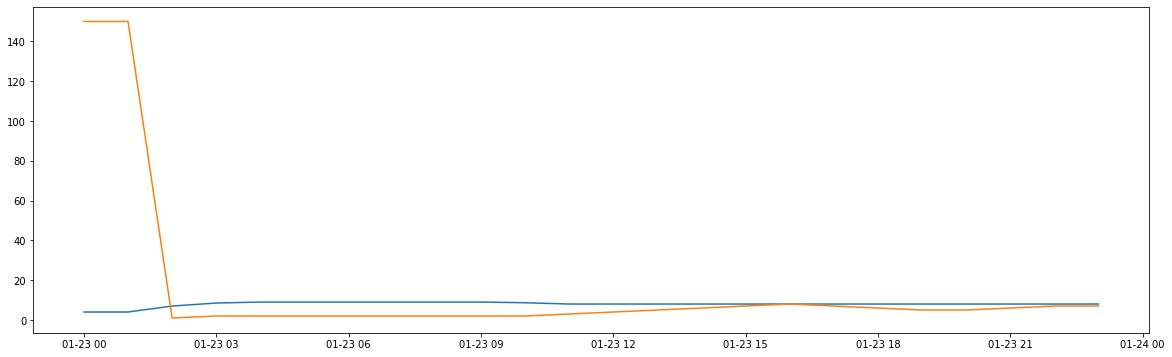

In [158]:
plt.figure(figsize=(20,6))
plt.plot(weather_check.index,weather_check['cloud_layer'])
plt.plot(weather_check.index,weather_check['cloud_base_height']);

MAPE
Rolling psuedo out of sample forward, also do it for different orders
Add more variables into the exogenous array
Find one location
Create multiple models and stitch them together
Figure out how to suppress things during night hours